In [80]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn import decomposition
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import csv
import time
import copy
import os
import tempfile

In [94]:
def normalize(data, stats):
    to_normalize = ['price','release_date','purchase_date','date_diff','total_positive_reviews',
            'total_negative_reviews','total_reviews','net_reviews','popularity','recommended']
    for n in to_normalize:
        if n in data.columns:
            data[n] = (data[n] - stats[n]['mean']) / stats[n]['std'] 


In [95]:
def pre_process(dataset):
    NOW = datetime.strptime('2019-10-31', '%Y-%m-%d')

    genres = dataset['genres'].str.get_dummies(',').add_prefix('g:')
    categories = dataset['categories'].str.get_dummies(',').add_prefix('c:')
    tags = dataset['tags'].str.get_dummies(',').add_prefix('t:')
    dataset = pd.concat([dataset, genres, categories, tags], axis=1)
    dataset.reset_index(inplace=True, drop=True)
    dataset.drop(['genres', 'categories', 'tags'], axis = 1, inplace=True)

    dataset['purchase_date'] = np.where(dataset['purchase_date'].isnull(), 
                                        dataset['release_date'], dataset['purchase_date'])
    dataset['total_positive_reviews'] = np.where(dataset['total_positive_reviews'].isnull(), 
                                        dataset['total_positive_reviews'].mean(), 
                                                 dataset['total_positive_reviews'])
    dataset['total_negative_reviews'] = np.where(dataset['total_negative_reviews'].isnull(), 
                                        dataset['total_negative_reviews'].mean(), 
                                                 dataset['total_negative_reviews'])

    dataset['is_free'] = dataset['is_free'].astype(int)
    dataset['release_date'] = (NOW - dataset['release_date']).astype('timedelta64[D]')
    dataset['purchase_date'] = (NOW - dataset['purchase_date']).astype('timedelta64[D]')
    
    dataset['date_diff'] = dataset['release_date'] - dataset['purchase_date']
    dataset['total_reviews'] = dataset['total_positive_reviews'] + dataset['total_negative_reviews']
    dataset['net_reviews'] = dataset['total_positive_reviews'] - dataset['total_negative_reviews']
    dataset['popularity'] = dataset['total_reviews'] / dataset['release_date']
    dataset['recommended'] = dataset['net_reviews'] / dataset['release_date']

    dataset.fillna(0, inplace=True)
    
    normalize(dataset, dataset.describe())

    return dataset

In [168]:
stamp = str(time.time_ns()//1000000)
print(stamp)

train_csv = pd.read_csv('msbd5001-fall2019/train.csv', parse_dates=['purchase_date', 'release_date'])
test_csv = pd.read_csv('msbd5001-fall2019/test.csv', parse_dates=['purchase_date', 'release_date'])

# train data and test data are processed together
# so they can use the same parameters to normalize 
# and contain the same dummy tags / genres / categories
all_data = pre_process(pd.concat([train_csv, test_csv]))

dataset = all_data.head(len(train_csv)).set_index("id")

# drop the outliers
dataset.drop([220,312,76], inplace=True) 

# divide the data into 3 sets for stratified sampling when splitting the data into training set and validation set
datasetA = dataset.loc[dataset['playtime_forever'] >= 8]
datasetB = dataset.loc[(dataset['playtime_forever'] < 8) & (dataset['playtime_forever'] >= 1)]
datasetC = dataset.loc[dataset['playtime_forever'] < 1]


1574927100530


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [169]:
train_dataA, val_dataA = train_test_split(datasetA, test_size=0.10)
train_dataB, val_dataB = train_test_split(datasetB, test_size=0.15)
train_dataC, val_dataC = train_test_split(datasetC, test_size=0.20)

train_data = dataset.loc[np.concatenate([train_dataA.index.values, train_dataB.index.values, train_dataC.index.values])]
val_data = dataset.loc[np.concatenate([val_dataA.index.values, val_dataB.index.values, val_dataC.index.values])]

# square root the target to reduce skewness
train_target = np.array(train_data.pop('playtime_forever'))**0.5
val_target = np.array(val_data.pop('playtime_forever'))**0.5

train_data = np.array(train_data)
val_data = np.array(val_data)


In [170]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred**2 - y_true**2),axis=-1))

def build_model(dim):
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_dim=dim, kernel_initializer='glorot_normal', 
                     kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(16, activation='relu', kernel_initializer='glorot_normal',
                    kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(1,activation='linear', kernel_initializer='glorot_normal')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[rmse])
    
    return model

class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('.', end='')
        if (epoch+1) % 10 == 0: 
            print(' ')
            logs_new = copy.deepcopy(logs)
            print(logs_new)

early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)            
            
EPOCHS = 150

model = build_model(train_data.shape[1])

history = model.fit(
    train_data, train_target,
    shuffle=True,
    epochs=EPOCHS, verbose=0, validation_data=(val_data, val_target), batch_size=20,
    callbacks=[PrintProgress(),early_stop])

.......... 
{'loss': 1.6081063366598554, 'rmse': 3.0865483, 'val_loss': 1.0982649421150035, 'val_rmse': 1.6969016}
.......... 
{'loss': 1.0161918292029037, 'rmse': 2.5300114, 'val_loss': 1.2156068312399315, 'val_rmse': 1.9886785}
.......... 
{'loss': 0.6629674782355627, 'rmse': 2.0426915, 'val_loss': 1.3078276368253159, 'val_rmse': 2.080607}
.......Epoch 00037: early stopping


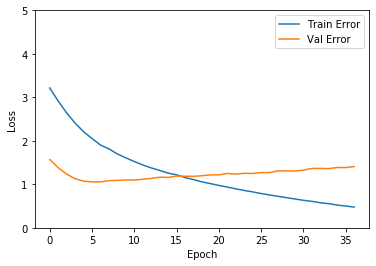

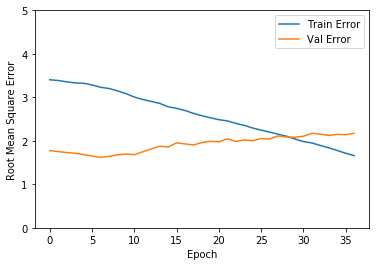

In [172]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_rmse'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.show()

plot_history(history)


In [173]:
test_data = all_data.tail(len(test_csv)).set_index("id")
test_data.pop('playtime_forever')

test_predict = model.predict(np.array(test_data))

file_name = 'result_'+stamp+'.csv'

with open(file_name, mode='w') as result_file:
    writer = csv.writer(result_file, delimiter=',')
    writer.writerow(['id', 'playtime_forever'])
    for i,f in enumerate(test_predict):
        r = f[0]**2 if f[0] > 0.1 else 0
        print(str(i)+','+str(r))
        writer.writerow([i, r])

0,0.7296401350397588
1,0.1901455784732775
2,0
3,0
4,5.624397938373079
5,0.33612893188637827
6,0
7,0
8,1.3469548815193235
9,0.9264082694064655
10,2.064843711708818
11,0
12,9.769988547326648
13,0.8179109892431349
14,2.0944856606310083
15,0
16,1.023468215932155
17,1.3975307794749483
18,2.3385859528080033
19,0.08517550089669612
20,0.09533650255186021
21,1.2263282916137541
22,0
23,0.12064616435907372
24,0.11928230649991267
25,0.021058727374472008
26,0
27,0.4642694902305635
28,0.31264183522640465
29,1.731807955068021
30,0.8412046139086584
31,16.100594783431234
32,0
33,0.011664703890929218
34,2.6416436521925704
35,0.5692291041523276
36,0.01799297586323778
37,11.05801159862699
38,2.9239639616576483
39,0
40,0.6024125051204123
41,0
42,3.441090968781978
43,0.723212145727814
44,0.38522135990021766
45,1.8723211216802724
46,0
47,0.11870206151174045
48,0
49,3.673028346499052
50,0.7719455034488334
51,0
52,0
53,0
54,0.016283303787336445
55,0.14743020870844337
56,0.08852936531412414
57,0.430139917269357

In [174]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 16)                6048      
_________________________________________________________________
dense_77 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 17        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [175]:
model_name = 'model_'+stamp+'.h5'
model.save(model_name)

In [ ]:
model = tf.keras.models.load_model('model.h5')

train_csv = pd.read_csv('msbd5001-fall2019/train.csv', parse_dates=['purchase_date', 'release_date'])
test_csv = pd.read_csv('msbd5001-fall2019/test.csv', parse_dates=['purchase_date', 'release_date'])
all_data = pre_process(pd.concat([train_csv, test_csv]))

test = all_data.tail(len(test_csv)).set_index("id")
test_data.pop('playtime_forever')
test_predict = model.predict(np.array(test_data))